In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")


[*********************100%***********************]  1 of 1 completed


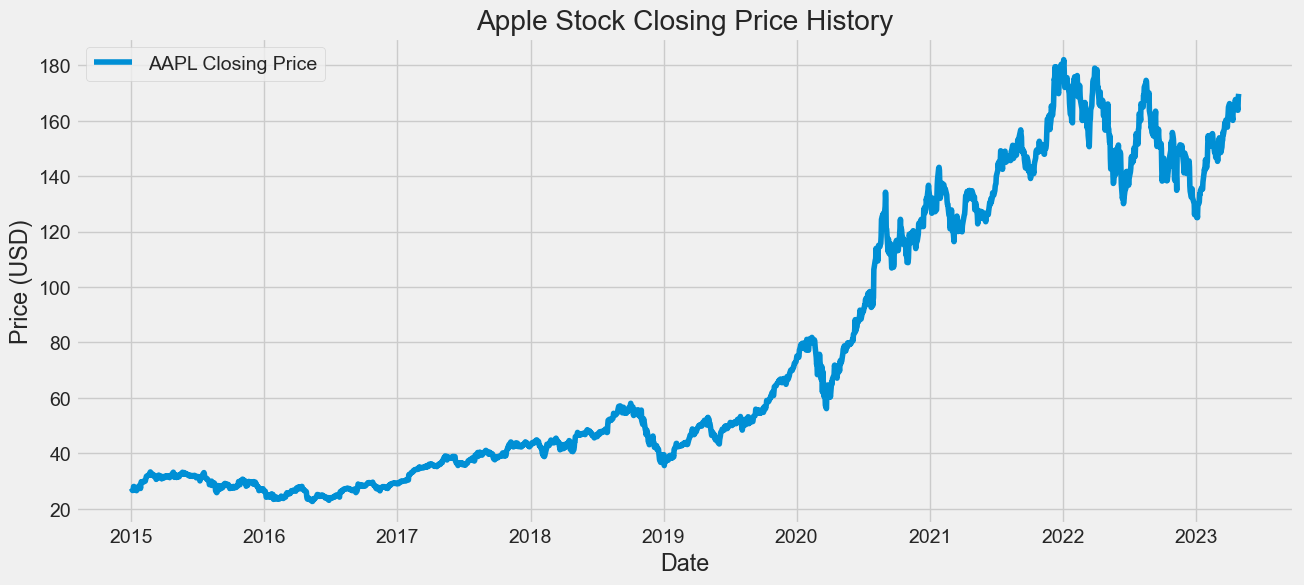

In [2]:
# Download stock data for the company (e.g., Apple Inc.)
stock_data = yf.download("AAPL", start="2015-01-01", end="2023-04-30")

# Plot the closing price
plt.figure(figsize=(14, 6))
plt.plot(stock_data['Close'], label="AAPL Closing Price")
plt.title('Apple Stock Closing Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [3]:
# Create a dataframe with only the 'Close' column
data = stock_data.filter(['Close'])
dataset = data.values

# Get the number of rows to train the model on (80% training data)
training_data_len = int(np.ceil( len(dataset) * .8 ))

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Create the training data set
train_data = scaled_data[0:int(training_data_len), :]

# Split the data into x_train and y_train datasets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data for LSTM input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [4]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)





1616/1616 [==============================] - 38s 21ms/step - loss: 0.0011


In [5]:
# Create the test data set
test_data = scaled_data[training_data_len - 60:, :]

# Create the x_test and y_test datasets
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert x_test to a numpy array
x_test = np.array(x_test)

# Reshape the data for LSTM input
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error: {rmse}")


14/14 [==============================] - 1s 15ms/step
Root Mean Squared Error: 6.393208575910324


C:\Users\janha\AppData\Local\Temp\ipykernel_23848\3590655650.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


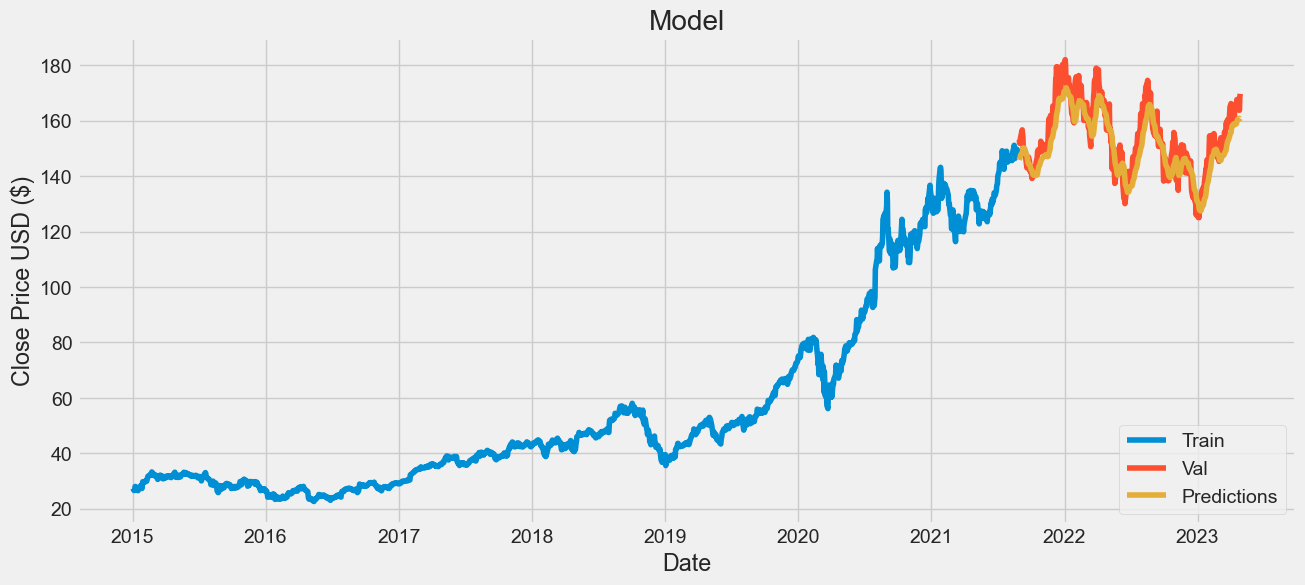

In [6]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(14, 6))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


In [7]:
# Show the valid and predicted prices
valid[['Close', 'Predictions']]


,Close,Predictions
Date,,
2021-08-30,153.119995,145.852921
2021-08-31,151.830002,146.247452
2021-09-01,152.509995,146.687805
2021-09-02,153.649994,147.175858
2021-09-03,154.300003,147.738113
...,...,...
2023-04-24,165.330002,160.707901
2023-04-25,163.770004,160.837021
2023-04-26,163.759995,160.772141
